<!--BOOK_INFORMATION-->

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

# In Depth: Naive Bayes Classification

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets.
Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem.

This section will focus on an intuitive explanation of how naive Bayes classifiers work, followed by a couple examples of them in action on some datasets.

## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods.
These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities.
In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

All we need now is some model by which we can compute $P({\rm features}~|~L_i)$ for each label.
Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.
The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

This is where the "naive" in "naive Bayes" comes in: 

If we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.
Different types of naive Bayes classifiers rest on different naive assumptions about the data, and we will examine a few of these in the following sections.

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Gaussian Naive Bayes

Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes.
In this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution*.
Imagine that you have the following data:

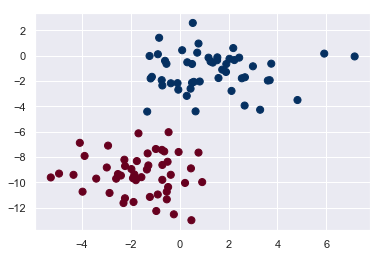

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions.
This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all you need to define such a distribution.
The result of this naive Gaussian assumption is shown in the following figure:


[(-15, 5), (-8, 8)]

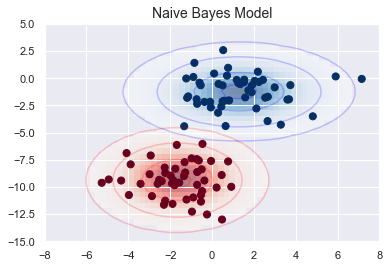

In [3]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.01)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9], #probabilities for which to draw ellipses
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

The ellipses here represent the Gaussian generative model for each label, with larger probability toward the center of the ellipses.
With this generative model in place for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn's ``sklearn.naive_bayes.GaussianNB`` estimator:

In [4]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Now let's generate some new data and predict the label:

In [5]:
rng = np.random.RandomState(0)
Xnew = [-8, -15] + [16, 20] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot this new data to get an idea of where the decision boundary is:

[(-15, 5), (-8, 8)]

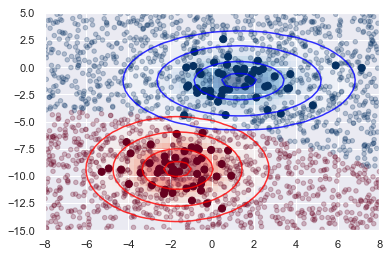

In [6]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
ax.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.25)

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    #notice we are now using mean and std found by GaussianNB
    mu = model.theta_[label,:]
    std = np.sqrt(model.sigma_[label,:])
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.01)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9], #probabilities for which to draw ellipses
               colors=color, alpha=0.8)

ax.set(xlim=xlim, ylim=ylim)

We see a slightly curved boundary in the classifications—in general, the boundary in Gaussian naive Bayes is quadratic.

A nice feature of this Bayesian formalism is that it naturally allows for probabilistic classification, which we can compute using the ``predict_proba`` method:

In [7]:
yprob = model.predict_proba(Xnew)
print(yprob[-15:].round(2))

[[0.   1.  ]
 [0.24 0.76]
 [0.   1.  ]
 [0.   1.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.89 0.11]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.   1.  ]
 [0.5  0.5 ]]


The columns give the posterior probabilities of the first and second label, respectively.
If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a useful approach.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results.
Still, in many cases—especially as the number of features becomes large—this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a useful method.

## Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.
Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution.

The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

### Example: Classifying Text

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.
Here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [8]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [9]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is a representative entry from the data:

In [10]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers.
For this we will use the TF-IDF vectorizer, and create a pipeline that attaches it to a multinomial naive Bayes classifier:

## Text Features

A common need in feature engineering is to convert text to a set of representative numerical values.
For example, most automatic mining of social media data relies on some form of encoding the text as numbers.
One of the simplest methods of encoding data is by *word counts*: you take each snippet of text, count the occurrences of each word within it, and put the results in a table.

For example:

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform([train.data[5],train.data[6]])
X
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,10,15,1919,20054,2493,ac,ago,airways,also,america,...,usa,use,washington,waste,who,will,william,with,years,your
0,1,1,1,1,1,0,1,1,1,1,...,1,1,1,0,1,0,0,1,1,1
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,2,1,0,0,0


There are some issues with this approach, however: The raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in some classification algorithms.
One approach to fix this is known as *term frequency-inverse document frequency* (*TF–IDF*) which weights the word counts by a measure of how often they appear in the documents.
The syntax for computing these features is similar to the previous example:

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform([train.data[5],train.data[6]])
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,10,15,1919,20054,2493,ac,ago,airways,also,america,...,usa,use,washington,waste,who,will,william,with,years,your
0,0.071916,0.071916,0.071916,0.071916,0.071916,0.000000,0.071916,0.071916,0.071916,0.071916,...,0.071916,0.071916,0.071916,0.000000,0.071916,0.000000,0.000000,0.071916,0.071916,0.071916
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.201902,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.201902,0.000000,0.403804,0.201902,0.000000,0.000000,0.000000


## Feature Pipelines

It can quickly become tedious to do transformations like this by hand, especially if you wish to string together multiple steps.

To streamline this into a type of processing pipeline, Scikit-Learn provides a ``Pipeline`` object, which can be used as follows:

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data.
The pipeline looks and acts like a standard Scikit-Learn object, and will apply all the specified steps to any input data.

In [14]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator.
For example, here is the confusion matrix between the true and predicted labels for the test data:

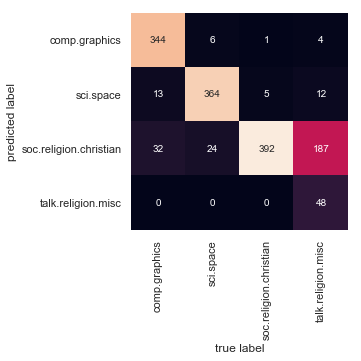

In [15]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity.
This is perhaps an expected area of confusion!

The very cool thing here is that we now have the tools to determine the category for *any* string, using the ``predict()`` method of this pipeline.
Here's a quick utility function that will return the prediction for a single string:

In [16]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Let's try it out:

In [17]:
predict_category('sending a payload to the ISS')

'sci.space'

In [18]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [19]:
predict_category('determining the screen resolution')

'comp.graphics'

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking.
Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

## When to Use Naive Bayes

Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as more complicated models.
That said, they have several advantages:

- They are extremely fast for both training and prediction
- They provide straightforward probabilistic prediction
- They are often very easily interpretable
- They have very few (if any) tunable parameters

These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification.
If it performs suitably, then congratulations: You have a very fast, very interpretable classifier for your problem.
If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in one of the following situations:

- When the naive assumptions actually match the data (very rare in practice)
- For very well-separated categories, when model complexity is less important
- For very high-dimensional data, when model complexity is less important

The last two points seem distinct, but they actually are related: As the dimension of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in *every single dimension* to be close overall).
This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information.
For this reason, simplistic classifiers like naive Bayes tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.
We will return to this topic in L08, "Breaking the Curse of Dimensionality".

## Assignment to go into journal J2

Apply a Naive Bayes classifier to the MNIST dataset.

Pick the version of Naive Bayes you think is best suited, and motivate your choice in the journal.

Specify your results using metrics of your own choice (again motivate in the journal), and perspectivise to previous results on the same dataset, e.g. are they comparable, better or worse, and make some suggestions why?

## Optional extension

Just like we extracted features from the texts above, it is common to extract features from images instead of using the raw pixel values.

Extract some features from MNIST images, and train/test your Naive Bayes on that.

Compare with results from raw pixels. Are your features better? Slower or faster?

Hints: You can for example use HOG (skimage.feature.hog) to extract image features. You probably need to try different parameters for the HOG transform.

It can be helpful to create a pipeline like we did above for the text features; for this you will need to create a 'transform' function that applies HOG. (You can look up how to make transform functions).
When creating transform functions for a pipeline you need to think about output from one transform matching input to the next transform..


In [20]:
from libitmal import dataloaders as dl
mnist = dl.GetMNISTRaw()

Fetched raw MNIST


In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

# Uses multinomial clf
X, y = dl.MNIST_GetDataSet(mnist)
mul_clf = MultinomialNB()

mul_clf.fit(X,y)
mul_clf_score = mul_clf.score(X,y)
print(mul_clf_score)

sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(X,y)
sgd_score = sgd_clf.score(X,y)
print(sgd_score)

0.8268571428571428


C:\Users\Fatima\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.8762714285714286
